Epoch 1/10
7108/7108 [==============================] - 21s 3ms/step - loss: 0.8062 - accuracy: 0.5955 - val_loss: 0.7942 - val_accuracy: 0.6354
Epoch 2/10
  40/7108 [..............................] - ETA: 18s - loss: 0.7969 - accuracy: 0.6234

C:\Users\HP\anaconda31\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7108/7108 [==============================] - 19s 3ms/step - loss: 0.7516 - accuracy: 0.6564 - val_loss: 0.7745 - val_accuracy: 0.6676
Epoch 3/10
7108/7108 [==============================] - 20s 3ms/step - loss: 0.7340 - accuracy: 0.6706 - val_loss: 0.7592 - val_accuracy: 0.6765
Epoch 4/10
7108/7108 [==============================] - 22s 3ms/step - loss: 0.7251 - accuracy: 0.6851 - val_loss: 0.7537 - val_accuracy: 0.6940
Epoch 5/10
7108/7108 [==============================] - 21s 3ms/step - loss: 0.7205 - accuracy: 0.6998 - val_loss: 0.7496 - val_accuracy: 0.7054
Epoch 6/10
7108/7108 [==============================] - 20s 3ms/step - loss: 0.7179 - accuracy: 0.7052 - val_loss: 0.7477 - val_accuracy: 0.7080
Epoch 7/10
7108/7108 [==============================] - 20s 3ms/step - loss: 0.7160 - accuracy: 0.7110 - val_loss: 0.7455 - val_accuracy: 0.7178
Epoch 8/10
7108/7108 [==============================] - 20s 3ms/step - loss: 0.7143 - accuracy: 0.7135 - val_loss: 0.7444 - val_accuracy: 0.7

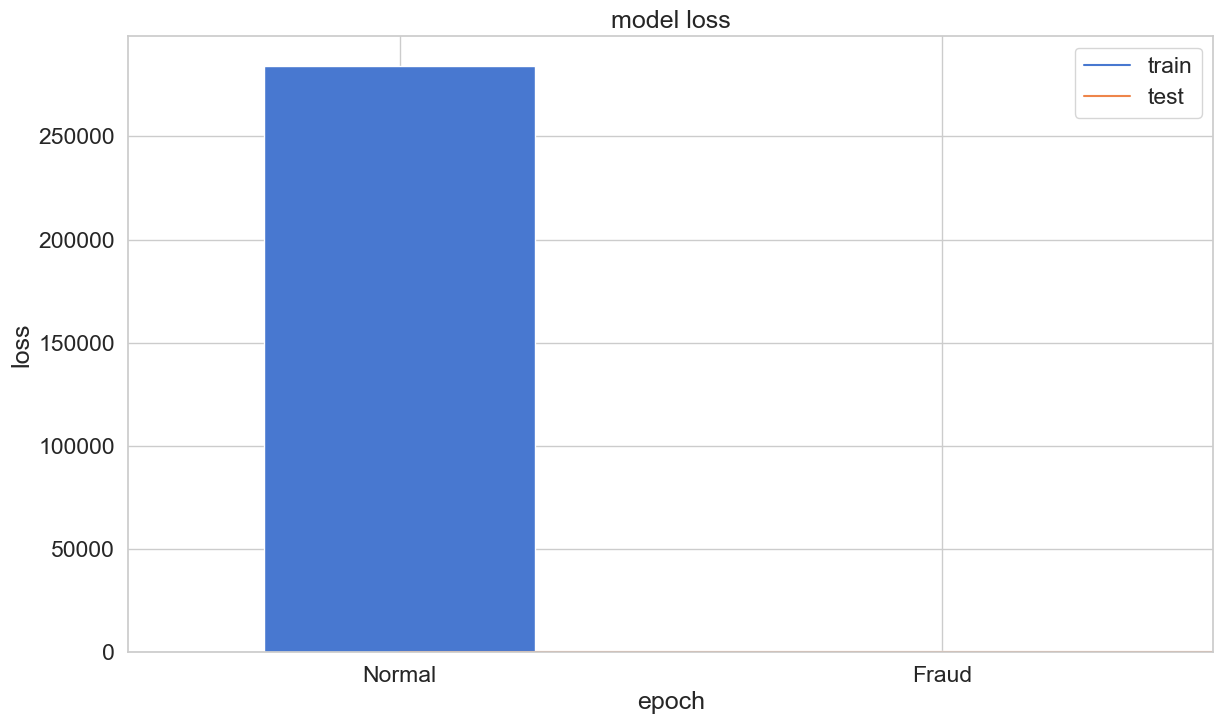

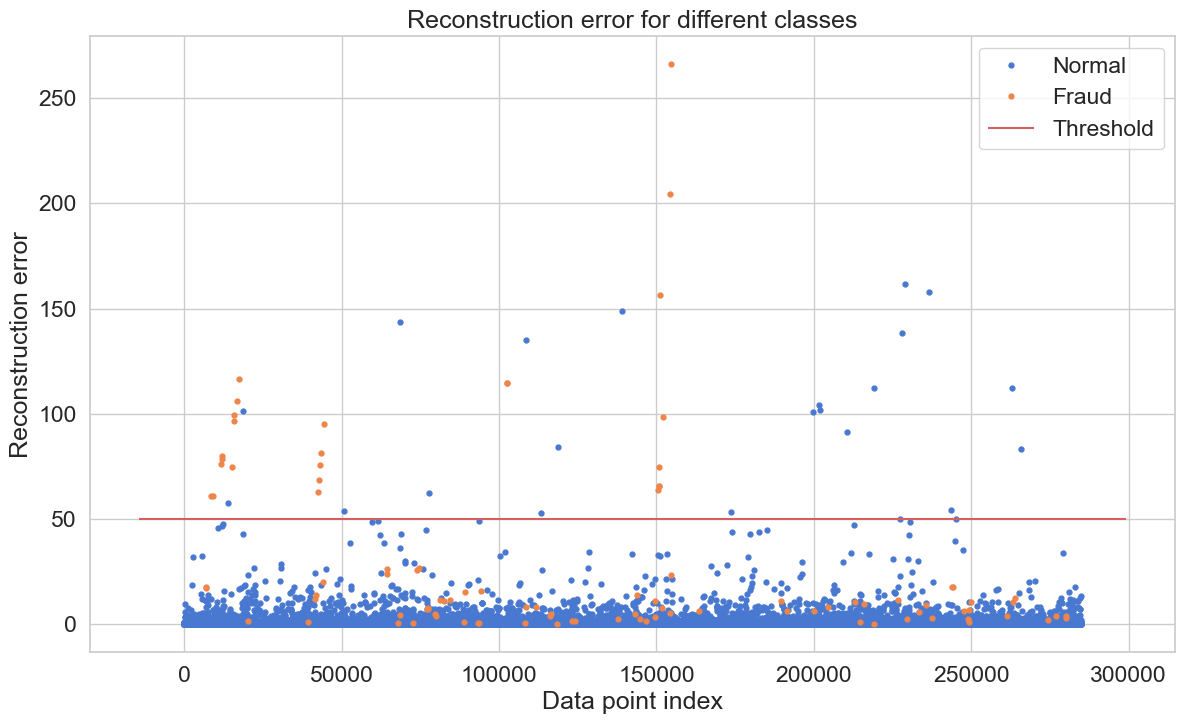

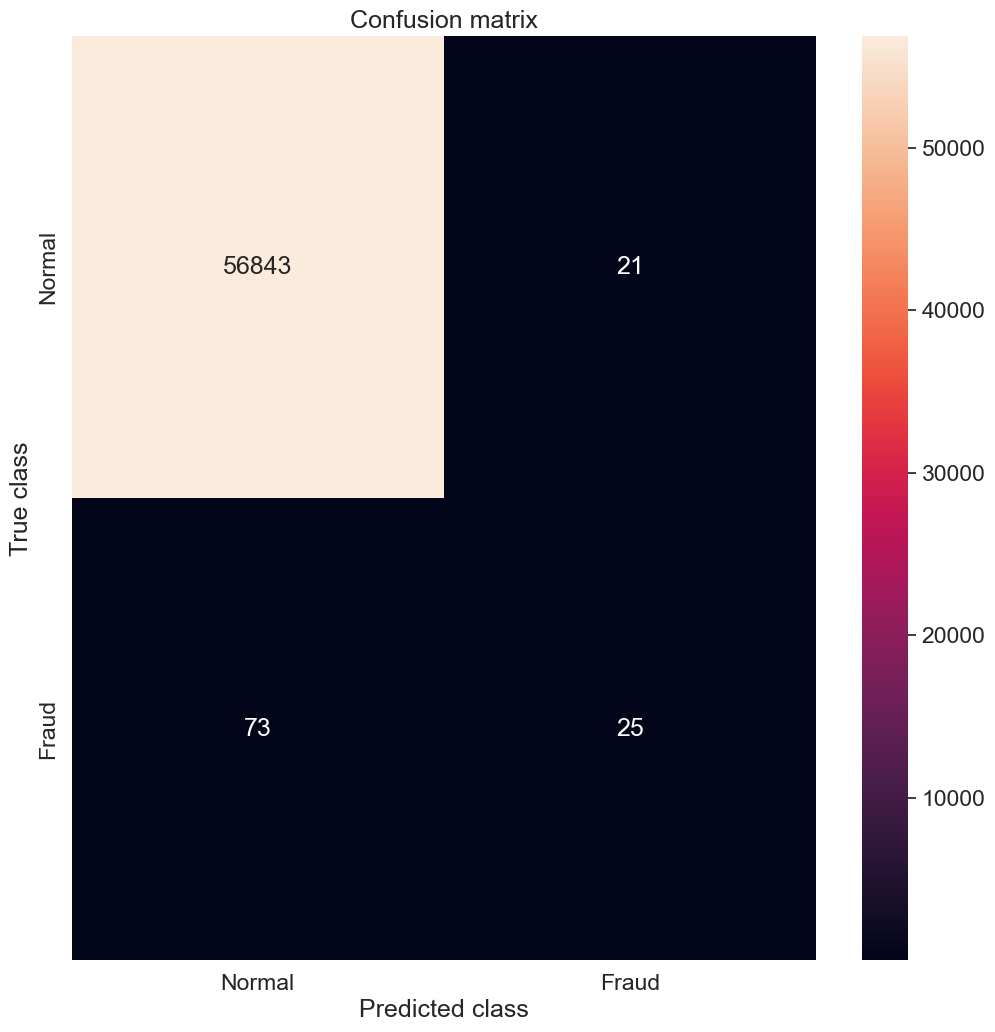

Accuracy: 0.9983497770443454
Recall: 0.25510204081632654
Precision: 0.5434782608695652


In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

df =  pd.read_csv("D:\creditcard.csv")

count_classes = pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency");

from sklearn.preprocessing import StandardScaler
data = df.drop(['Time'], axis=1)
data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

X_train, X_test = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED)
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)
y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)
X_train = X_train.values
X_test = X_test.values

input_dim = X_train.shape[1]
encoding_dim = 14

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="tanh",
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)
decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

nb_epoch = 10
batch_size = 32
early_stop = tf.keras.callbacks. EarlyStopping( monitor= 'val_loss', min_delta=0.0001, patience=10, verbose=1, mode='min',
                                               restore_best_weights=True)
autoencoder.compile(optimizer='adam',
                    loss='mean_squared_error',
                    metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)
history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer, early_stop]).history

plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

predictions = autoencoder.predict(X_test)

mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})

error_df.describe()

threshold = 50
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

from sklearn.metrics import confusion_matrix,recall_score,accuracy_score,precision_score

y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

error_df['pred'] = y_pred

print("Accuracy:",accuracy_score (error_df['true_class'],error_df['pred']))
print("Recall:",recall_score(error_df['true_class'],error_df['pred']))
print("Precision:",precision_score(error_df['true_class'],error_df['pred']))
